# Projeto 2 - Ciência dos Dados
## 2020.2 ~ 2C ~ Estudo do stat "Velocidade" dos Pokémons
### Grupo:
    -Guilherme Rameh
    -Tales Oliveira
    -Gabriella Zullo
    -João Magalhães

In [115]:
import scipy.stats as stats
from scipy.stats import t, norm, probplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, ceil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sns
%matplotlib inline

In [116]:
dados = pd.read_csv('pokemon.csv')
dados

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,['Beast Boost'],0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,...,NaN,797,107,101,61,steel,flying,999.9,7,1
797,['Beast Boost'],1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,...,NaN,798,59,31,109,grass,steel,0.1,7,1
798,['Beast Boost'],2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,...,NaN,799,97,53,43,dark,dragon,888.0,7,1
799,['Prism Armor'],2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,...,NaN,800,127,89,79,psychic,NaN,230.0,7,1


In [117]:
print(dados.dtypes)

abilities             object
against_bug          float64
against_dark         float64
against_dragon       float64
against_electric     float64
against_fairy        float64
against_fight        float64
against_fire         float64
against_flying       float64
against_ghost        float64
against_grass        float64
against_ground       float64
against_ice          float64
against_normal       float64
against_poison       float64
against_psychic      float64
against_rock         float64
against_steel        float64
against_water        float64
attack                 int64
base_egg_steps         int64
base_happiness         int64
base_total             int64
capture_rate          object
classfication         object
defense                int64
experience_growth      int64
height_m             float64
hp                     int64
japanese_name         object
name                  object
percentage_male      float64
pokedex_number         int64
sp_attack              int64
sp_defense    

##### Quando lidando com duas variáveis QUANTITATIVAS, usamos scatter plot, e para variáveis QUALITATÍVAS (como estamos lidando com "speed", que é quantitativo) podemos separar por index e fazer crosstab, ou usar o comando pivot table do pandas, que permite a análise de várias variáveis qualitativas em relação a quantitativas, permitindo até o uso de comandos como média, máx e mín.

In [118]:
shuffle = dados.sample(frac=1)
shuffle

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
440,"['Keen Eye', 'Tangled Feet', 'Big Pecks']",0.50,1.0,1.0,2.0,1.0,1.00,1.0,1.0,0.0,...,50.0,441,92,42,91,normal,flying,1.9,4,0
167,"['Swarm', 'Insomnia', 'Sniper']",0.50,1.0,1.0,1.0,0.5,0.25,2.0,2.0,1.0,...,50.0,168,60,70,40,bug,poison,33.5,2,0
557,"['Sturdy', 'Shell Armor', 'Weak Armor']",1.00,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,50.0,558,65,75,45,bug,rock,200.0,5,0
556,"['Sturdy', 'Shell Armor', 'Weak Armor']",1.00,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,50.0,557,35,35,55,bug,rock,14.5,5,0
44,"['Chlorophyll', 'Effect Spore']",1.00,1.0,1.0,0.5,0.5,0.50,2.0,2.0,1.0,...,50.0,45,110,90,50,grass,poison,18.6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,"['Static', 'Limber', 'Sand Veil']",1.00,1.0,1.0,0.0,1.0,1.00,1.0,0.5,1.0,...,50.0,618,81,99,32,ground,electric,11.0,5,0
577,"['Overcoat', 'Magic Guard', 'Regenerator']",2.00,2.0,1.0,1.0,1.0,0.50,1.0,1.0,2.0,...,50.0,578,125,60,30,psychic,NaN,8.0,5,0
370,"['Rock Head', 'Sheer Force']",1.00,1.0,2.0,0.5,2.0,1.00,0.5,1.0,1.0,...,50.0,371,40,30,50,dragon,NaN,42.1,3,0
145,"['Pressure', 'Flame Body']",0.25,1.0,1.0,2.0,0.5,0.50,0.5,1.0,1.0,...,NaN,146,125,85,90,fire,flying,60.0,1,1


In [119]:
size = 600
list_of_dfs = [shuffle.iloc[:600,:], shuffle.iloc[600:,:]]
train = list_of_dfs[0]
test = list_of_dfs[1]

In [120]:
# Aqui vemos a quantidade de cada tipo, 1 e 2, na base de treino

print(train['type1'].value_counts())
print('\n')
print(train['type2'].value_counts())

water       91
normal      74
grass       61
bug         60
fire        40
psychic     35
rock        34
electric    33
dark        23
ground      22
poison      22
fighting    20
ghost       19
dragon      19
steel       16
ice         15
fairy       13
flying       3
Name: type1, dtype: int64


flying      72
poison      29
ground      24
fairy       20
psychic     20
steel       19
dark        17
fighting    15
ice         14
ghost       12
water       12
dragon      12
rock        12
fire        10
grass        9
electric     6
bug          4
normal       1
Name: type2, dtype: int64


In [220]:
for i in train.index:
    type1 = train.type1[i]
    if type1 == 'water':
        train.loc[train.name==train.name[i], 'Type1Reorder'] = 'water'
    elif type1 == 'normal':
        train.loc[train.name==train.name[i], 'Type1Reorder'] = 'normal'
    else:
        train.loc[train.name==train.name[i], 'Type1Reorder'] = 'other'
        
    type2 = train.type2[i]
    if type2 == 'flying':
        train.loc[train.name==train.name[i], 'Type2Reorder'] = 'flying'
    elif type2 == 'poison':
        train.loc[train.name==train.name[i], 'Type2Reorder'] = 'poison'
    else:
        train.loc[train.name==train.name[i], 'Type2Reorder'] = 'other'
        
train.head(5)

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary,Type1Reorder,Type2Reorder
440,"['Keen Eye', 'Tangled Feet', 'Big Pecks']",0.5,1.0,1.0,2.0,1.0,1.00,1.0,1.0,0.0,...,92.0,42.0,91.0,normal,flying,1.9,4.0,0.0,normal,flying
167,"['Swarm', 'Insomnia', 'Sniper']",0.5,1.0,1.0,1.0,0.5,0.25,2.0,2.0,1.0,...,60.0,70.0,40.0,bug,poison,33.5,2.0,0.0,other,poison
557,"['Sturdy', 'Shell Armor', 'Weak Armor']",1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,65.0,75.0,45.0,bug,rock,200.0,5.0,0.0,other,other
556,"['Sturdy', 'Shell Armor', 'Weak Armor']",1.0,1.0,1.0,1.0,1.0,1.00,1.0,1.0,1.0,...,35.0,35.0,55.0,bug,rock,14.5,5.0,0.0,other,other
44,"['Chlorophyll', 'Effect Spore']",1.0,1.0,1.0,0.5,0.5,0.50,2.0,2.0,1.0,...,110.0,90.0,50.0,grass,poison,18.6,1.0,0.0,other,poison


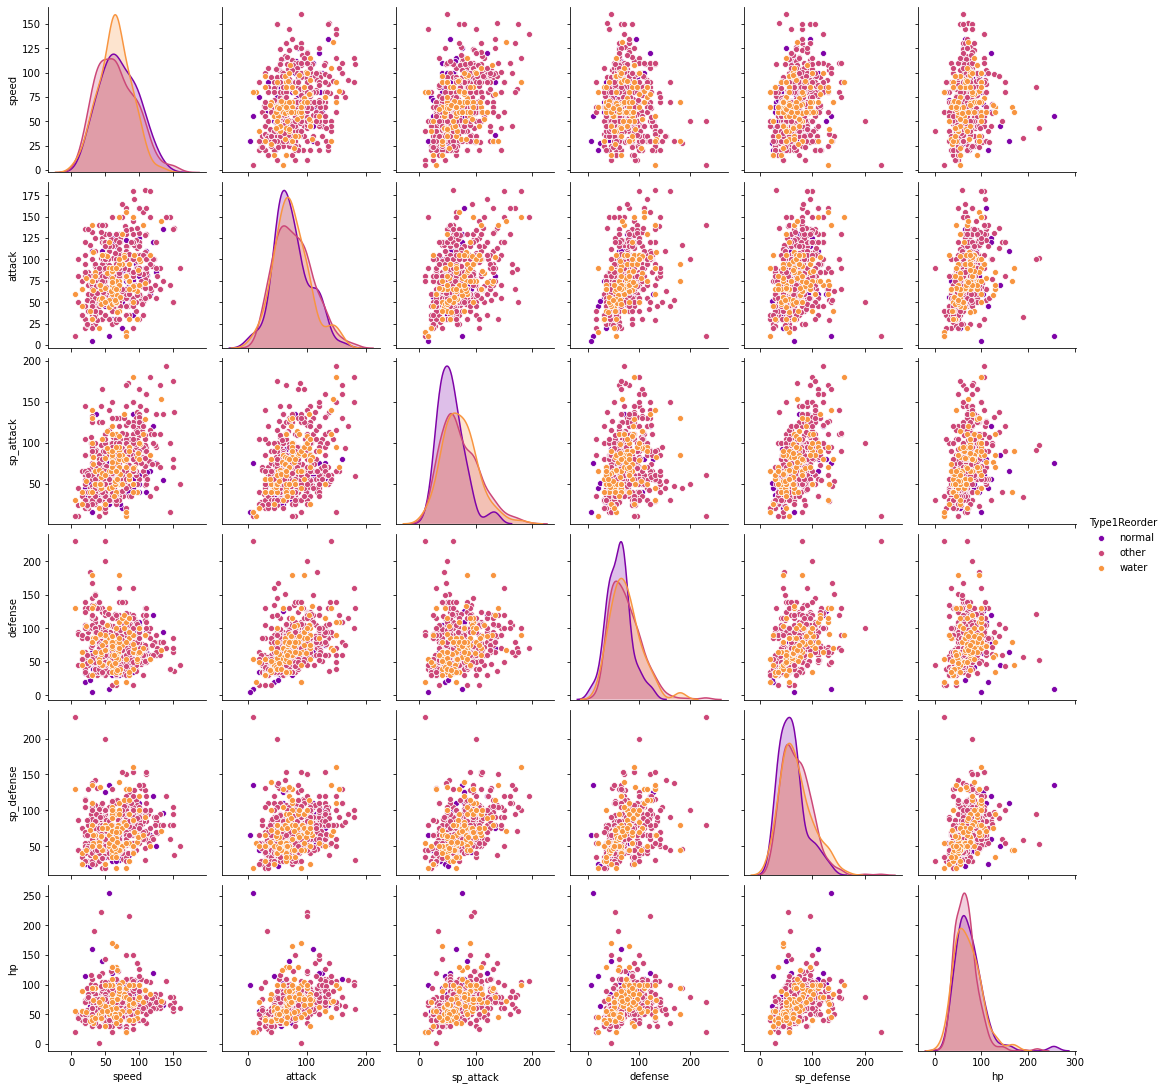

In [211]:
df = train.loc[:, ['speed', 'attack', 'sp_attack', 'defense', 'sp_defense', 'hp', 'Type1Reorder', 'Type2Reorder']]
sns.pairplot(df, height=2.5, hue='Type1Reorder', palette='plasma');

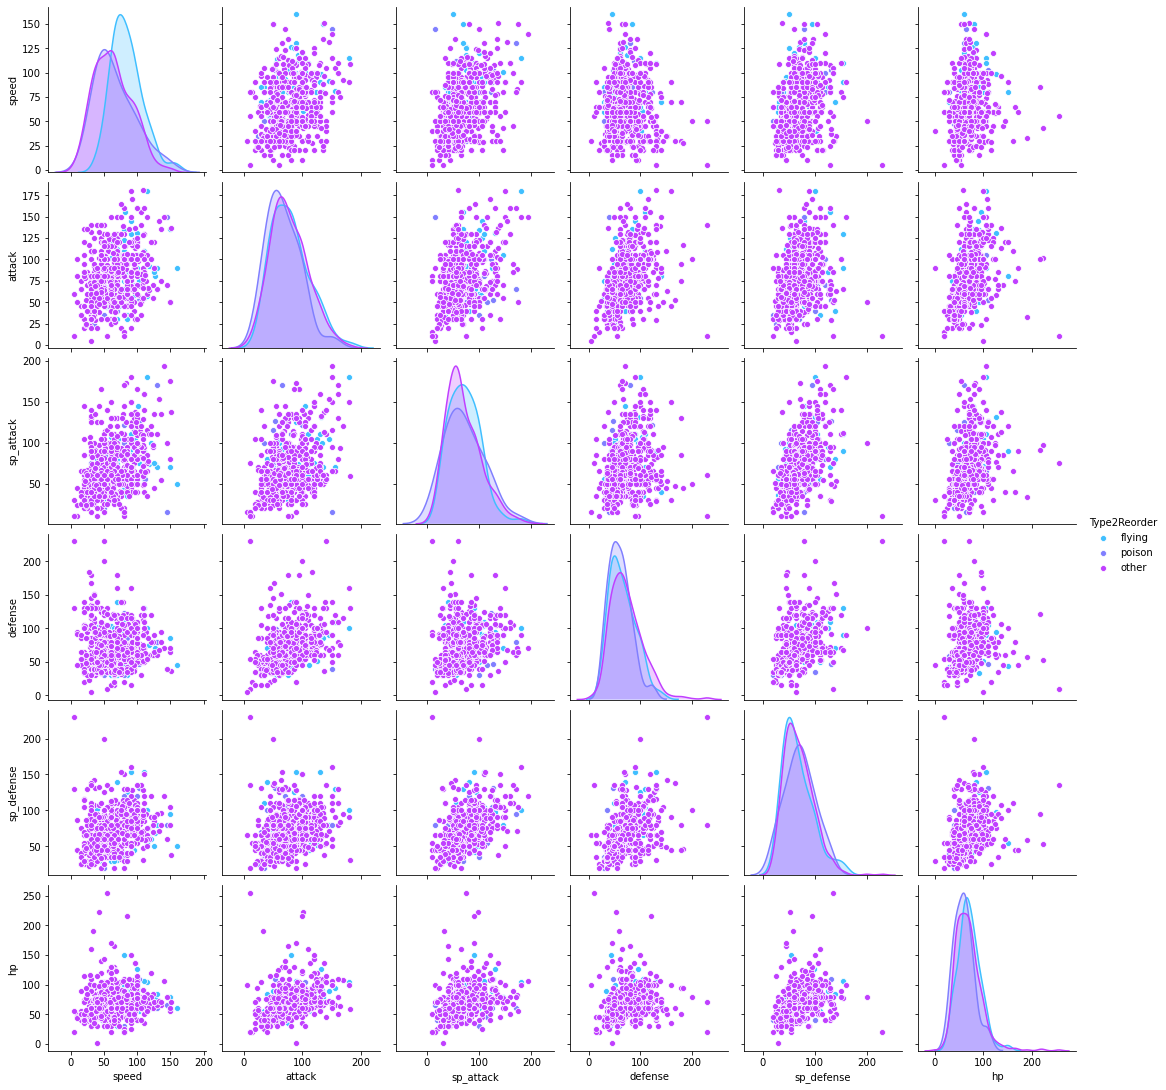

In [215]:
sns.pairplot(df, height=2.5, hue='Type2Reorder', palette='cool');